# Fast Neural Style Transfer (google/arbitrary-image-stylization-v1) 
ref:https://arxiv.org/abs/1705.06830

In [4]:
import tensorflow as tf

In [5]:
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
from pathlib import Path
import shutil
import numpy as np
import operator
from dataclasses import dataclass
import time
from datetime import timedelta

## Import Model from Model Hub

In [6]:
@dataclass
class G:
    env="kaggle"
    if env == "kaggle":
        style_img_dir_path="/kaggle/input/gan-getting-started/monet_jpg"
        content_img_dir_path="/kaggle/input/gan-getting-started/photo_jpg"
        model = hub.load('/kaggle/input/arbitrary-image-stylization-v1/tensorflow1/256/2')
    else:
        model  = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
        style_img_dir_path = os.getcwd()+"/monet_jpg"
        content_img_dir_path=os.getcwd()+"/photo_jpg"

## Load Image

In [7]:
def load_img(path_to_img):
    image = tf.io.read_file(path_to_img)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    return image

def load_images(content_path, style_path):
    content_image = load_img("{}".format(content_path))
    style_image = load_img("{}".format(style_path))

    return content_image, style_image

## Transfer Style

In [8]:
def load_style_ds(style_img_dir):
    ds=tf.keras.preprocessing.image_dataset_from_directory(style_img_dir,labels=None, color_mode='grayscale',
                                                          batch_size=100)
    ds=ds.map(lambda image: tf.image.convert_image_dtype(image, tf.uint8))
    return ds

In [9]:
def calculate_ssmin(content_image, style_image):
    ssim_score= tf.image.ssim(content_image, style_image,256)
    return ssim_score

In [10]:
trial=load_style_ds(G.style_img_dir_path)

Found 300 files.


In [11]:
def find_matches(content_img_path,style_img_ds, verbose):
    scores={}
    starttime = time.perf_counter()
    
    content_image=load_img("{}".format(content_img_path))
    content_image=tf.image.rgb_to_grayscale(content_image)
    style_image_paths=list(os.walk(G.style_img_dir_path))[0][2]
    for images in style_img_ds:
        for style_image_path,style_img in zip(style_image_paths,images):
            ssim_score=calculate_ssmin(content_image, style_img)
            ssim_score=ssim_score.numpy() 
            style_image_path_full=G.style_img_dir_path+"/"+style_image_path
            scores[style_image_path_full]=abs(ssim_score)
    
    match=max(scores.items(), key=operator.itemgetter(1))[0]
    duration = timedelta(seconds=time.perf_counter()-starttime)
    if verbose:
        print("computation time for finding match: ", duration)
    return match

In [12]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

Found 300 files.
computation time for finding match:  0:00:32.625528
computation time for style and content images loading:  0:00:00.004741
computation time for style transfer:  0:00:01.974060


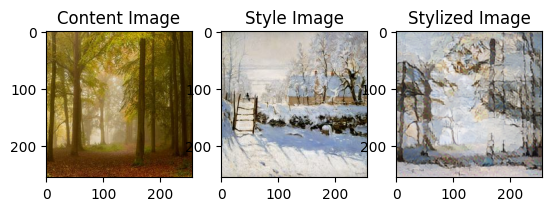

time it took to save image:  0:00:00.012977
******************************************************************
computation time for finding match:  0:00:32.682608
computation time for style and content images loading:  0:00:00.005137
computation time for style transfer:  0:00:00.745991


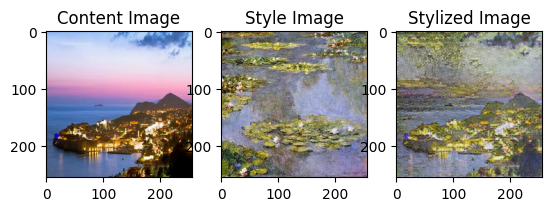

time it took to save image:  0:00:00.002064
******************************************************************
computation time for finding match:  0:00:33.144936
computation time for style and content images loading:  0:00:00.011528
computation time for style transfer:  0:00:00.768004


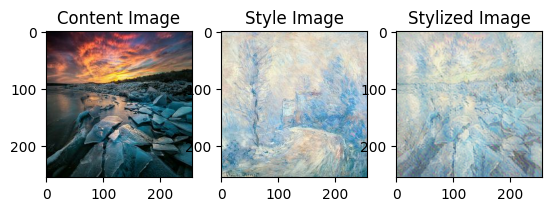

time it took to save image:  0:00:00.002615
******************************************************************
computation time for finding match:  0:00:32.753824
computation time for style and content images loading:  0:00:00.005551
computation time for style transfer:  0:00:00.760642


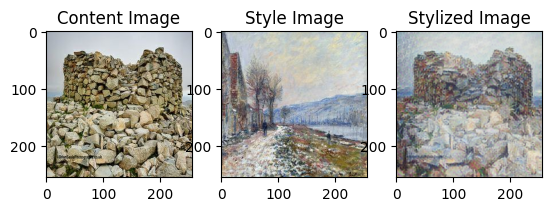

time it took to save image:  0:00:00.002531
******************************************************************
computation time for finding match:  0:00:32.771144
computation time for style and content images loading:  0:00:00.004623
computation time for style transfer:  0:00:00.750168


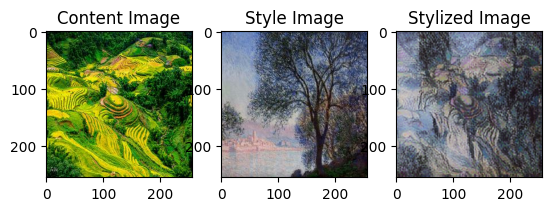

time it took to save image:  0:00:00.002217
******************************************************************


In [ ]:
def predict(content_dir, style_img_dir, path="/kaggle/working/tmp/"):
    if os.path.isdir(path):
        shutil.rmtree(path)
    Path(path).mkdir(parents=True, exist_ok=True)
    style_image_ds=load_style_ds(style_img_dir).take(1)
    print_sample=5
    for i, content_img_path in enumerate(content_dir):
        if i<print_sample:
            style_img_path=find_matches(content_img_path,style_image_ds, verbose=True)
        else:
            style_img_path=find_matches(content_img_path,style_image_ds, verbose=False)
        
        if i<print_sample:
            starttime = time.perf_counter()
        content_image, style_image = load_images(content_img_path, style_img_path)
        if i<print_sample:
            duration = timedelta(seconds=time.perf_counter()-starttime)
            print("computation time for style and content images loading: ", duration)
        if i<print_sample:
            plt.subplot(1, 3, 1)
            imshow(content_image, 'Content Image')

            plt.subplot(1, 3, 2)
            imshow(style_image, 'Style Image')
        if i<print_sample:
            starttime = time.perf_counter()
        stylized_image = G.model(tf.image.convert_image_dtype(content_image[tf.newaxis, :], tf.float32),
                            tf.image.convert_image_dtype(style_image[tf.newaxis, :], tf.float32))[0]
        if i<print_sample:
            duration = timedelta(seconds=time.perf_counter()-starttime)
            print("computation time for style transfer: ", duration)
        
        tensor_shape=tf.shape(stylized_image)
        number_elem_shape = tf.shape(tensor_shape)
        if number_elem_shape > 3:
            assert tensor_shape[0] == 1
            stylized_image = stylized_image[0]
            
        if i<print_sample:
            plt.subplot(1, 3, 3)
            imshow(stylized_image, 'Stylized Image')
            plt.show()
            plt.close()
        if i<print_sample:
            starttime = time.perf_counter()
        im=tf.keras.preprocessing.image.array_to_img(stylized_image)
        im.save(path + str(i) + ".jpg")
        if i<print_sample:
            duration = timedelta(seconds=time.perf_counter()-starttime)
            print("time it took to save image: ", duration)
            print("*"*66)


if G.env=="kaggle":
    content_dir = glob.glob(os.path.join("/kaggle/input/gan-getting-started/photo_jpg", "*.jpg"))
    predict(content_dir, G.style_img_dir_path)
else:
    content_dir = glob.glob(os.path.join(os.getcwd()+"/photo_jpg", "*.jpg"))
    predict(content_dir, G.style_img_dir_path, path=os.getcwd()+"/tmp/")

In [ ]:
import shutil
if G.env=="kaggle":
    shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/working/tmp/")
else:
    shutil.make_archive(os.getcwd()+"/images", 'zip', os.getcwd()+"/tmp/")